In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import pandas as pd
import os
import json
import re
import scipy as sp
import pickle

import nltk
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
import numpy as np
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import faiss
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics.pairwise import cosine_similarity
from scipy.special import softmax
from scipy.sparse import csr_matrix

import nltk
nltk.download('punkt')

import warnings
warnings.filterwarnings('ignore')

import random
random.seed(1234)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
data_dir = '/content/gdrive/MyDrive/MLDS/Data_Mining/Project/data/final_data'
os.listdir(data_dir)

['testset.csv',
 'trainset_rec.csv',
 'process_user_business_data_v1.json',
 'testset_ind.csv',
 'trainset_rec_ind.csv',
 'train_tfidf_matrix.npz',
 'tfidf_vectorizer.pkl',
 'svd_500_tfidf_matrix.npy',
 'train_data.json',
 'test_data.json',
 'user_profiles.pkl',
 'item_profiles.pkl',
 'user_item_matrix.pkl',
 'user_sim_matrix.pkl']

In [ ]:
# Loading Base DataFrame
base_df = pd.read_json(os.path.join(data_dir, 'process_user_business_data_v1.json'))
base_df.head(2)

,review_id,user_id,business_id,stars_x,useful,funny,cool,text,date,name,...,state,postal_code,latitude,longitude,stars_y,review_count,is_open,attributes,categories,hours
0,2fA_8TK24PULHnFz4CE_JA,B7d4_zvYzjE1D-E2fSw9LA,gGyqnAlpFrka_qzpO7j4lQ,2,1,5,2,To the other reviewers \nYou are reviewing the...,2009-05-19 19:12:28,Citizens Bank Park,...,PA,19176,39.905993,-75.166640,4.5,515,1,"{'GoodForKids': 'True', 'DogsAllowed': 'False'...","Active Life, Baseball Fields, Stadiums & Arena...",None
1,D9Toy0Ve0j77tp2iHVW3HA,92KVnXQL9KH5A_aX-lnEdA,NeY1bH6IKJxnn4YAixibsQ,2,0,0,0,"Good menu, solid ingredients, but these folks ...",2014-04-19 19:45:40,Cosi,...,PA,19104,39.953671,-75.194957,2.5,115,0,"{'RestaurantsGoodForGroups': 'True', 'Business...","Coffee & Tea, Restaurants, Sandwiches, Food","{'Monday': '0:0-0:0', 'Tuesday': '7:0-22:0', '..."


In [ ]:
base_df.columns

Index(['review_id', 'user_id', 'business_id', 'stars_x', 'useful', 'funny',
       'cool', 'text', 'date', 'name', 'address', 'city', 'state',
       'postal_code', 'latitude', 'longitude', 'stars_y', 'review_count',
       'is_open', 'attributes', 'categories', 'hours'],
      dtype='object')

In [ ]:
#base_df[base_df.business_id == base_df.business_id.unique()[0]].stars_y.unique()

In [ ]:
# Reading train and test user and business data
train_df = pd.read_csv(os.path.join(data_dir, 'trainset_rec_ind.csv'))
test_df = pd.read_csv(os.path.join(data_dir, 'testset_ind.csv'))

cols_to_use = ['review_id','user_id', 'business_id']

train_df = train_df[cols_to_use]
test_df = test_df[cols_to_use]

print(f"Train Size : {train_df.shape}")
print(f"Test Size : {test_df.shape}")

Train Size : (240464, 3)
Test Size : (67278, 3)


In [ ]:
train_df.head(2)

,review_id,user_id,business_id
0,LEGT4hPIyEVMzy4HUROtoQ,-1MF2tosrw2WcCxeVNk81Q,9c7MUiE6VI8NesjPdj5FkA
1,QvoAHbml7mkqFrx9K18h2Q,-1MF2tosrw2WcCxeVNk81Q,1OfhM-ZKvcpxyxptCCzEwA


In [ ]:
test_df.head(2)

,review_id,user_id,business_id
0,-PjpaGU8xu2xv6zMqB7sMg,TVN3qoXU0-sateboutdCZg,dBRWKIS7h-qZCi8EjUJ2HA
1,9vYKLUjAy6KJ4Ky0u8_PQg,DgC8Z8VmSAlWZpsc_XjbqQ,2EMTsTg8876QbtIGDH-69w


In [ ]:
def merge_data(base_df, target_df, merge_on='review_id'):
  """
  Merge the train/test df with the base_df on review_id and extract other meta data
  """
  final_df = target_df.merge(base_df, on=merge_on, how='inner')

  assert final_df.shape[0] == target_df.shape[0]
  final_df.rename(columns={'stars_y' : 'item_rating',
                           'stars_x' : 'user_rating',
                           'user_id_x' : 'user_id',
                           'business_id_x' : 'business_id',
                           }, inplace=True)
  final_df.drop(columns=['business_id_y','user_id_y'],axis=1, inplace=True)
  return final_df

In [ ]:
# Merging the train and test data with base df
train_df = merge_data(base_df = base_df, target_df = train_df)
test_df = merge_data(base_df = base_df, target_df = test_df)

print(train_df.shape[0])
print(test_df.shape[0])

240464
67278


In [ ]:
train_df.head(2)

,review_id,user_id,business_id,user_rating,useful,funny,cool,text,date,name,...,state,postal_code,latitude,longitude,item_rating,review_count,is_open,attributes,categories,hours
0,LEGT4hPIyEVMzy4HUROtoQ,-1MF2tosrw2WcCxeVNk81Q,9c7MUiE6VI8NesjPdj5FkA,3,4,0,1,A coworker and I stopped by here for an aftern...,2017-12-13 22:58:16,Bubblefish,...,PA,19107,39.953679,-75.155108,4.0,544,1,"{'RestaurantsReservations': 'True', 'Caters': ...","Restaurants, Sushi Bars, Japanese, Bubble Tea,...","{'Monday': '11:0-23:30', 'Tuesday': '11:0-23:3..."
1,QvoAHbml7mkqFrx9K18h2Q,-1MF2tosrw2WcCxeVNk81Q,1OfhM-ZKvcpxyxptCCzEwA,4,4,0,0,Stopped by here for happy hour and was fairly ...,2017-08-01 22:47:11,Independence Beer Garden,...,PA,19106,39.950294,-75.150981,3.5,513,1,"{'HappyHour': 'True', 'RestaurantsTableService...","Bars, Nightlife, American (New), Gastropubs, F...","{'Monday': '0:0-0:0', 'Wednesday': '15:0-0:0',..."


In [ ]:
test_df.head(2)

,review_id,user_id,business_id,user_rating,useful,funny,cool,text,date,name,...,state,postal_code,latitude,longitude,item_rating,review_count,is_open,attributes,categories,hours
0,-PjpaGU8xu2xv6zMqB7sMg,TVN3qoXU0-sateboutdCZg,dBRWKIS7h-qZCi8EjUJ2HA,4,3,0,3,Love it here. This is a great museum to play w...,2016-04-06 01:52:34,The Franklin Institute Science Museum,...,PA,19103,39.958211,-75.173137,4.0,623,1,"{'GoodForKids': 'True', 'BusinessAcceptsCredit...","Cinema, Museums, Venues & Event Spaces, Event ...","{'Wednesday': '10:0-17:0', 'Thursday': '10:0-1..."
1,9vYKLUjAy6KJ4Ky0u8_PQg,DgC8Z8VmSAlWZpsc_XjbqQ,2EMTsTg8876QbtIGDH-69w,4,1,0,2,Great place to meet up with friends & top off ...,2019-06-10 13:42:28,Uptown Beer Garden,...,PA,19103,39.953910,-75.169230,3.0,49,0,"{'GoodForDancing': 'False', 'BusinessParking':...","Beer Gardens, Nightlife, Beer, Wine & Spirits,...","{'Monday': '17:0-22:0', 'Tuesday': '17:0-22:0'..."


In [ ]:
# Saving Train and Test DataFrame
train_df.to_json(os.path.join(data_dir, 'train_data.json'))
test_df.to_json(os.path.join(data_dir, 'test_data.json'))

In [ ]:
train_df = pd.read_json(os.path.join(data_dir, 'train_data.json'))
test_df = pd.read_json(os.path.join(data_dir, 'test_data.json'))

In [ ]:
# Processing and Cleaning text reviews

def clean_text(text):
  # Remove special characters and digits
  text = re.sub(r'[^a-zA-Z\s]', '', text, re.I|re.A)
  # Remove digits
  text = re.sub(r'\d', '', text)
  # Convert to lowercase
  text = text.lower()
  # Remove extra spaces
  text = text.strip()
  return text

def tokenize_text(text):
  return word_tokenize(text)

def process_reviews(document):
  # Clean Text , tokenize text and join again
  cleaned_text = tokenize_text(clean_text(document))
  cleaned_text = ' '.join(cleaned_text)
  cleaned_text = cleaned_text.strip()
  return cleaned_text

In [ ]:
# Process the reviews in the data
train_df['processed_text'] = train_df['text'].apply(lambda x : process_reviews(x))
test_df['processed_text'] = test_df['text'].apply(lambda x : process_reviews(x))

In [ ]:
# Creating TF-IDF Matrix
tfidf_params = {
    "min_df" : 0.01, # terms that appear in less than 1% of the documents
    "max_features" : 10000, # keep the most frequent 10000 terms
    "smooth_idf" : True,    # adds one to document frequencies
    "sublinear_tf" : True,  # apply sublinear tf scaling
    "norm" : 'l2',          # L2-normalize vectors
    "use_idf" : True,       # enable IDF reweighting
    "ngram_range" : (1, 2)  # include both unigrams and bigrams
}
tfidf_vectorizer = TfidfVectorizer(**tfidf_params)
tfidf_matrix = tfidf_vectorizer.fit_transform(train_df['processed_text'])
tfidf_matrix.shape

(240464, 2275)

In [ ]:
# Saving TFIDF Matrix
#sp.sparse.save_npz(os.path.join(data_dir,'train_tfidf_matrix.npz'), tfidf_matrix)

# Sample loading code
tfidf_matrix = sp.sparse.load_npz(os.path.join(data_dir,'train_tfidf_matrix.npz'))

In [ ]:
with open(os.path.join(data_dir,'tfidf_vectorizer.pkl'), 'wb') as fin:
    pickle.dump(tfidf_vectorizer, fin)

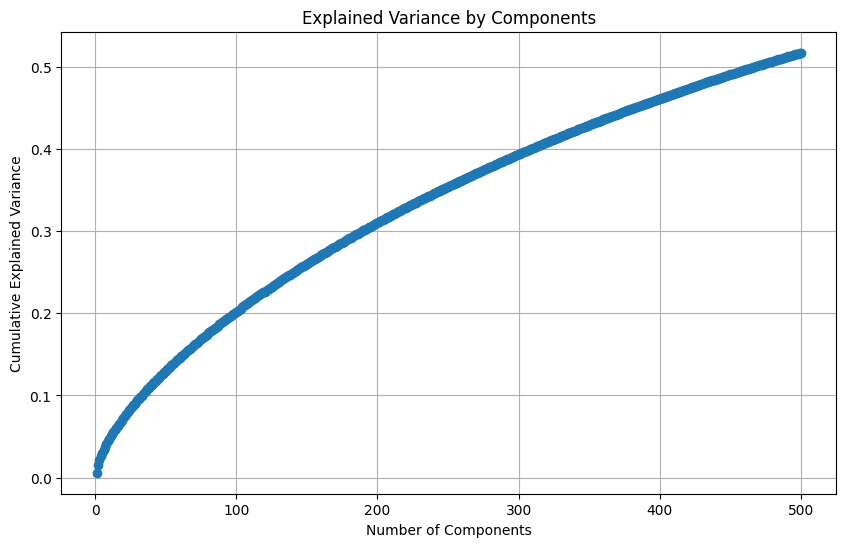

In [ ]:
# Since the matrices are very large in dimension and also sparse in nature , Lets reduce the dimensions using SVD
svd = TruncatedSVD(n_components=500)  # Use n-1 components to explore variance
tfidf_reducded = svd.fit_transform(tfidf_matrix)

# Calculate cumulative explained variance
cumulative_explained_variance = np.cumsum(svd.explained_variance_ratio_)

# Plot the cumulative explained variance
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, marker='o', linestyle='--')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by Components')
plt.grid(True)
plt.show()

In [ ]:
np.save(os.path.join(data_dir,'svd_500_tfidf_matrix.npy'), tfidf_reducded)

In [ ]:
tfidf_reduced = np.load(os.path.join(data_dir,'svd_500_tfidf_matrix.npy'))
print(tfidf_reduced.shape)

(240464, 500)


In [ ]:
profile_arr = tfidf_reduced.tolist()
train_df['profiles'] = profile_arr

In [ ]:
train_df.head(2)

,review_id,user_id,business_id,user_rating,useful,funny,cool,text,date,name,...,postal_code,latitude,longitude,item_rating,review_count,is_open,attributes,categories,hours,profiles
0,LEGT4hPIyEVMzy4HUROtoQ,-1MF2tosrw2WcCxeVNk81Q,9c7MUiE6VI8NesjPdj5FkA,3,4,0,1,A coworker and I stopped by here for an aftern...,2017-12-13 22:58:16,Bubblefish,...,19107,39.953679,-75.155108,4.0,544,1,"{'RestaurantsReservations': 'True', 'Caters': ...","Restaurants, Sushi Bars, Japanese, Bubble Tea,...","{'Monday': '11:0-23:30', 'Tuesday': '11:0-23:3...","[0.3774101195072007, 0.03681087464086613, 0.00..."
1,QvoAHbml7mkqFrx9K18h2Q,-1MF2tosrw2WcCxeVNk81Q,1OfhM-ZKvcpxyxptCCzEwA,4,4,0,0,Stopped by here for happy hour and was fairly ...,2017-08-01 22:47:11,Independence Beer Garden,...,19106,39.950294,-75.150981,3.5,513,1,"{'HappyHour': 'True', 'RestaurantsTableService...","Bars, Nightlife, American (New), Gastropubs, F...","{'Monday': '0:0-0:0', 'Wednesday': '15:0-0:0',...","[0.37589675238662057, 0.03794432240557088, -0...."


In [ ]:
def extract_user_profiles(df):
  """
  Extract item profiles by grouping by user id and taking mean review vector
  """
  user_groups = df.groupby('user_id')
  user_profiles = {}
  for usergrp in tqdm(user_groups):
      profiles = np.array([np.array(profile) for profile in np.array(usergrp[1]['profiles'])])
      mean_profile = np.mean(profiles,axis=0)
      user_profiles[usergrp[0]] = mean_profile
  return user_profiles

def extract_item_profiles(df):
  """
  Extract item profiles by grouping by business id and taking mean review vector
  """
  item_groups = df.groupby('business_id')
  item_profiles = {}
  for itemrgrp in tqdm(item_groups):
      profiles = np.array([np.array(profile) for profile in np.array(itemrgrp[1]['profiles'])])
      mean_profile = np.mean(profiles,axis=0)
      item_profiles[itemrgrp[0]] = mean_profile
  return item_profiles

In [ ]:
user_profiles = extract_user_profiles(df = train_df)
item_profiles = extract_item_profiles(df = train_df)

100%|██████████| 12739/12739 [00:11<00:00, 1077.56it/s]


In [ ]:
print(f"Number of user profiles : {len(user_profiles)}")
print(f"Number of item profiles : {len(item_profiles)}")

Number of user profiles : 6395
Number of item profiles : 12739


In [ ]:
with open(os.path.join(data_dir, 'user_profiles.pkl'), 'wb') as f:
  pickle.dump(user_profiles, f)

with open(os.path.join(data_dir, 'item_profiles.pkl'), 'wb') as f:
  pickle.dump(item_profiles, f)